# letters: 0-255, spacer:256, blank(e):257

In [23]:
BLANK_VAL = 257

#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *


In [24]:
dna_vocab = list(range(255))#.append(['spacer','blank'])
dna_vocab.append('spacer')
dna_vocab.append('blank')
dna_vocab.append('_')
print(dna_vocab)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [25]:
#! 

class DNA_vocab:
    # character and index is the same for this task    
    def __init__(self, dna_vocab):
        self.dna_vocab = dna_vocab
    def vocab(self):
        return dna_vocab
    def id_to_subword(self,id):
        return dna_vocab[id]

In [26]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [27]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

c:\Users\nntin\uni\fyp\quartznet-pytorch


In [28]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

Sequence 3 of 3
Generated 9 signals and 9 labels in 0.0470000000204891


Letters: [89, 56, 165, 40, 132, 143, 174] 
barcodes: [1, 2] 
ctc_labels: [256, 89, 256, 56, 256, 165, 256, 40, 256, 132, 256, 143, 256, 174, 256]
9
[1975, 1727, 1836, 1839, 1936, 1953, 1989, 2106, 2070]
2106


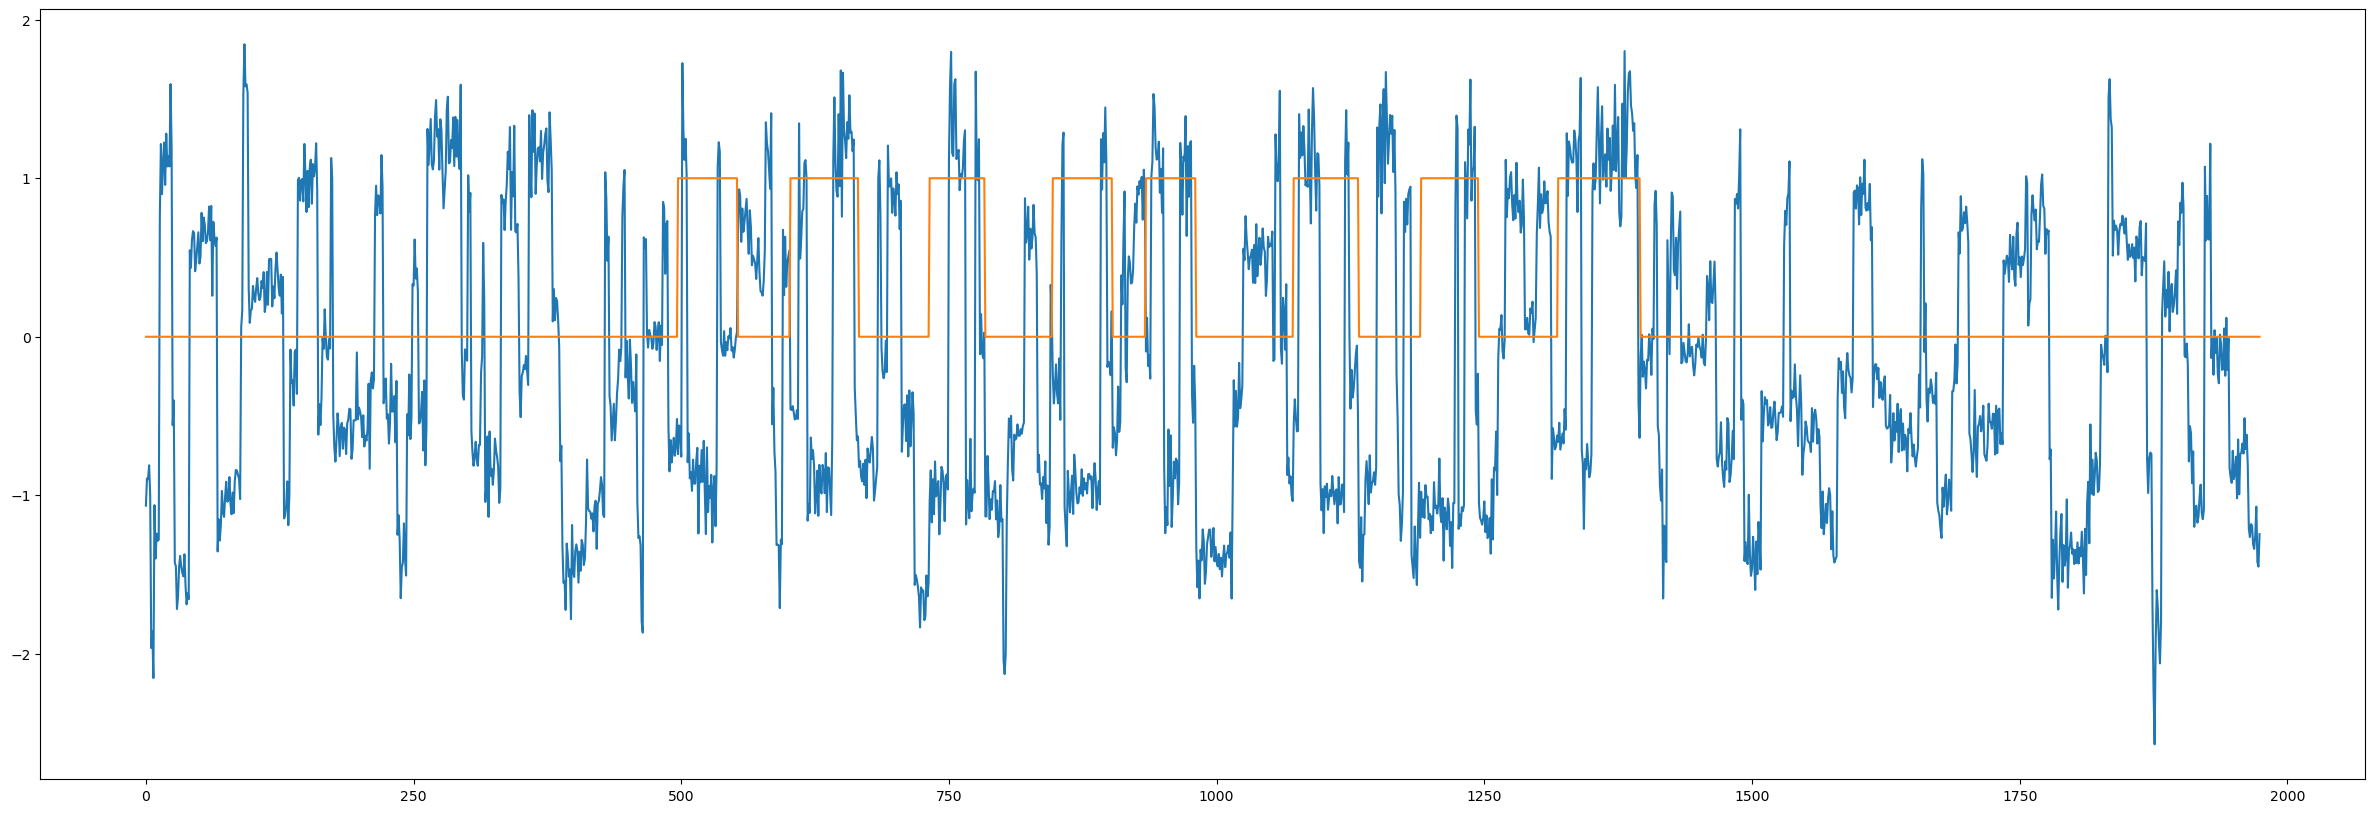

In [29]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

In [30]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [31]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [32]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 258, 'feat_in': 1}}

In [33]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)
bpe = DNA_vocab(dna_vocab)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze() #! Tin add
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get(
    #         'sample_rate', 16000),  # for LJspeech
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad(), # pad both audio and text
    AudioUnsqueeze() #! Tin add
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

# print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()


criterion = nn.CTCLoss(blank=BLANK_VAL, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe,blank_index=BLANK_VAL,space_simbol='_')

prev_wer = 1000
#! TIN CHNAGE
# wandb.init(project=config.wandb.project, config=config)
# wandb.watch(model, log="all", log_freq=config.wandb.get(
#     'log_interval', 5000))

label
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

In [34]:
print(bpe.vocab())
bpe.vocab().index('_')
int_to_char = bpe.id_to_subword
int_to_char(257)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

'_'

In [35]:
b=train_dataset.__getitem__(2)
b['audio'].shape

(1836,)

In [36]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print((b['input_lengths']))
print((b['target_lengths']))
print(b['text'].shape)

print(b['audio'].dtype)
print(b['text'].dtype)


3
8
8
1975
5
8
8
torch.Size([8, 1, 2106])
tensor([1975, 1727, 1836, 1839, 1936, 1953, 1989, 2106], device='cuda:0')
tensor([15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')
torch.Size([8, 15])
torch.float64
torch.int32


In [37]:
print(b.keys())

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])


In [38]:

for epoch_idx in tqdm(range(config.train.get('epochs', 10))):
    # train:
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        batch1=batch
        # print(len(batch1['audio'][0]))
        batch = batch_transforms_train(batch)
        batch2=batch
        # print(len(batch2['audio'][0]))

        optimizer.zero_grad()
        print('batch audio shape:', batch['audio'].shape, batch['audio'].dtype )
        logits = model(batch['audio'].float())
        print('logits shape:', logits.shape)
        
        output_length = torch.ceil(
            batch['input_lengths'].float() / model.stride).int()
        print('output_length shape:',output_length)
        print('target_lengths:',batch['target_lengths'])
        
        loss = criterion(logits.permute(2, 0, 1).log_softmax(
            dim=2), batch['text'], output_length, batch['target_lengths']) # target_length is the length of text of batch1 (before batch aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config.train.get('clip_grad_norm', 15))
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()
        break
        if batch_idx % config.wandb.get('log_interval', 5000) == 0:
            target_strings = decoder.convert_to_strings(batch['text'])
            decoded_output = decoder.decode(
                logits.permute(0, 2, 1).softmax(dim=2))
            wer = np.mean([decoder.wer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            cer = np.mean([decoder.cer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            step = epoch_idx * \
                len(train_dataloader) * train_dataloader.batch_size + \
                batch_idx * train_dataloader.batch_size
            wandb.log({
                "train_loss": loss.item(),
                "train_wer": wer,
                "train_cer": cer,
                "train_samples": wandb.Table(
                    columns=['gt_text', 'pred_text'],
                    data=zip(target_strings, decoded_output)
                )
            }, step=step)
    # #!
    # # validate:
    # model.eval()
    # val_stats = defaultdict(list)
    # for batch_idx, batch in enumerate(val_dataloader):
    #     batch = batch_transforms_val(batch)
    #     with torch.no_grad():
    #         logits = model(batch['audio'])
    #         output_length = torch.ceil(
    #             batch['input_lengths'].float() / model.stride).int()
    #         loss = criterion(logits.permute(2, 0, 1).log_softmax(
    #             dim=2), batch['text'], output_length, batch['target_lengths'])

    #     target_strings = decoder.convert_to_strings(batch['text'])
    #     decoded_output = decoder.decode(
    #         logits.permute(0, 2, 1).softmax(dim=2))
    #     wer = np.mean([decoder.wer(true, pred)
    #                     for true, pred in zip(target_strings, decoded_output)])
    #     cer = np.mean([decoder.cer(true, pred)
    #                     for true, pred in zip(target_strings, decoded_output)])
    #     val_stats['val_loss'].append(loss.item())
    #     val_stats['wer'].append(wer)
    #     val_stats['cer'].append(cer)
    # for k, v in val_stats.items():
    #     val_stats[k] = np.mean(v)
    # val_stats['val_samples'] = wandb.Table(
    #     columns=['gt_text', 'pred_text'], data=zip(target_strings, decoded_output))
    # wandb.log(val_stats, step=step)

    # # save model, TODO: save optimizer:
    # if val_stats['wer'] < prev_wer:
    #     os.makedirs(config.train.get(
    #         'checkpoint_path', 'checkpoints'), exist_ok=True)
    #     prev_wer = val_stats['wer']
    #     torch.save(
    #         model.state_dict(),
    #         os.path.join(config.train.get(
    #             'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth')
    #     )
    #     wandb.save(os.path.join(config.train.get(
    #         'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth'))
    break

  0%|          | 0/42 [00:00<?, ?it/s]

batch audio shape: torch.Size([8, 1, 2106]) torch.float64


  0%|          | 0/42 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.29 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
logits.permute(2, 0, 1).log_softmax(
            dim=2).shape

torch.Size([1117, 8, 120])

In [ ]:
batch2.keys()

In [ ]:
batch2['input_lengths']

In [ ]:
print(len(batch1['audio'])) # batchsize
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(max([len(x) for x in batch1['audio'] ]))

In [ ]:
a=train_dataset.dataset.__getitem__(0)
print(a)
# len(train_dataset.dataset.__getitem__(0)['text'])
print(a['text'].shape)

In [ ]:
# load datasets
train_dataset_2 = dataset_module.get_dataset(
    config, part='train')
b = train_dataset_2.dataset.__getitem__(0)
# len(train_dataset_2.dataset.__getitem__(0)['text'])
print(b)
import string
translator = str.maketrans('', '', string.punctuation)
print(len(b['text'].translate(translator)))

In [ ]:
len(batch1['audio'][0])
len(batch2['audio'][0])
print(len(batch1['text'][2]))
print(len(batch2['text'][1]))
